<a href="https://colab.research.google.com/github/Psyclophe/Data-Scientist/blob/main/Wal_mart_analysis_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
from pandas.core.indexes.datetimes import date
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels as sm
import sklearn as sl

!pip install pmdarima

import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mutti

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.compat.scipy import _next_regular

import warnings
warnings.filterwarnings ("ignore")

from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## sección 1.***Obtención de Datos***
es este apartado se sube la información del dataFrame en github





In [2]:
#se cargan los datos de entrada proporcionado en el proyecto de las tiendas Wal-mart, asimismo se hace la conexión de los datos a Github mostrado en la siguiente ruta
#de la misma forma se indica a Python muestre los primeros "15" registros

url = 'https://raw.githubusercontent.com/Psyclophe/Data-Scientist/main/Walmart_Store_sales.csv'
df = pd.read_csv (url)
print('Shape of data',df.shape)
df.head(15)

Shape of data (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


## sección 2. **Análisis Exploratorio**
en esta sección se procede a realizar el análisis de la información proporcionada con Python

In [3]:
#para identificar el tipo de datos se pide a Python que nos muestre los diferentes tipos datos y, poder detectar la cantidad de datos nulos
df.isnull().sum(axis=0)

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [4]:
#con la carga de informacion y con esta funcion se pide a Python indicar el tipo de dato de cada columna, para analizar si es necesario hacer cambios en el tipo de 
#dato en el dataframe y poder tener datos homogeneos se identifico que "Date" es un dato que es objeto y se debe convertir a dato fecha
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [6]:
#en esta funcion se pide a Python convertir los datos objeto a string aquí podemos visualizar que el dato que era un objeto "Date" se conviritio al formato fecha 
#en donde se visualiza "datetime64[ns]"
df["Date"]=pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [7]:
#con este script se pide a Pyhon poner en formato a las cifras de la informacion de dataset
pd.options.display.float_format='{:,.2f}'.format

In [8]:
#con esta funcion se da la instrucción a Python para ver las medidas de tendencia central de las 8 columnas
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,"6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00","6,435.00"
mean,23.00,"1,046,964.88",0.07,60.66,3.36,171.58,8.00
std,12.99,"564,366.62",0.26,18.44,0.46,39.36,1.88
min,1.00,"209,986.25",0.00,-2.06,2.47,126.06,3.88
25%,12.00,"553,350.10",0.00,47.46,2.93,131.74,6.89
50%,23.00,"960,746.04",0.00,62.67,3.44,182.62,7.87
75%,34.00,"1,420,158.66",0.00,74.94,3.73,212.74,8.62
max,45.00,"3,818,686.45",1.00,100.14,4.47,227.23,14.31


In [9]:
#se da la instruccion a Python que se ordene las fechas de menor a mayor en el archivo que se va a analizar asimismo se indica al programa que ordene por fechas, 
#de la mas antigua hasta la mas reciente
data_sort=df.sort_values("Date")
data_sort

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
606,5,2010-01-10,"283,178.12",0,71.10,2.60,212.23,6.77
2036,15,2010-01-10,"566,945.95",0,59.69,2.84,132.76,8.07
5897,42,2010-01-10,"481,523.93",0,86.01,3.00,126.23,9.00
4610,33,2010-01-10,"224,294.39",0,91.45,3.00,126.23,9.27
5039,36,2010-01-10,"422,169.47",0,74.66,2.57,210.44,8.48
...,...,...,...,...,...,...,...,...
5860,41,2012-12-10,"1,409,544.97",0,39.38,3.76,199.05,6.20
2285,16,2012-12-10,"491,817.19",0,43.26,3.76,199.05,5.85
1427,10,2012-12-10,"1,713,889.11",0,76.03,4.47,131.11,6.94
3572,25,2012-12-10,"697,317.41",0,43.74,4.00,216.12,7.29


In [10]:
#con este script se pide a Python separar el dato "Date" en year, quarter, month, week & day,
df["Year"]= df['Date'].dt.year
df["Quarter"]= df['Date'].dt.quarter
df["Month"]= df['Date'].dt.month
df["Week"]= df['Date'].dt.week
df["Day"]= df['Date'].dt.day
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-05-02,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,17,2
1,1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-05-03,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-05-10,"733,455.07",0,64.89,3.98,192.17,8.67,2012,2,5,19,10
6432,45,2012-12-10,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,12,50,10
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


In [11]:
#con la funcion "groupby" se indica a Python agrupar y sumar, por tienda y por semana, al ejecutar el script Python agrega e indexa la columna "0" a la columna "1" 
#como identificador
group=df.groupby("Store").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,"222,402,808.85",10,"9,767.87",460.42,"30,887.56","1,088.29",287568,357,926,3718,2238
1,2,"275,382,440.98",10,"9,754.94",460.42,"30,837.42","1,090.21",287568,357,926,3718,2238
2,3,"57,586,735.07",10,"10,215.09",460.42,"31,372.99","1,026.31",287568,357,926,3718,2238
3,4,"299,543,953.38",10,"8,902.23",460.03,"18,401.19",852.95,287568,357,926,3718,2238
4,5,"45,475,688.90",10,"9,925.65",460.42,"30,968.88",900.24,287568,357,926,3718,2238
5,6,"223,756,130.64",10,"9,967.10",460.42,"31,110.11",944.79,287568,357,926,3718,2238
6,7,"81,598,275.14",10,"5,680.00",463.54,"27,693.99","1,227.76",287568,357,926,3718,2238
7,8,"129,951,181.13",10,"8,939.50",460.42,"31,379.78",871.13,287568,357,926,3718,2238
8,9,"77,789,218.99",10,"9,691.85",460.42,"31,406.62",872.28,287568,357,926,3718,2238
9,10,"271,617,713.89",10,"10,330.49",511.36,"18,401.19","1,195.90",287568,357,926,3718,2238


In [12]:
#se solicita a Python ordenar por tienda y por volumen de ventas, del valor mayor al menor
sort_WeeklySales=group.sort_values('Weekly_Sales', ascending=False)
sort_WeeklySales

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
19,20,"301,397,792.46",10,"7,929.55",488.72,"29,892.45","1,054.11",287568,357,926,3718,2238
3,4,"299,543,953.38",10,"8,902.23",460.03,"18,401.19",852.95,287568,357,926,3718,2238
13,14,"288,999,911.34",10,"8,264.11",488.72,"26,638.85","1,236.77",287568,357,926,3718,2238
12,13,"286,517,703.80",10,"7,678.69",469.92,"18,401.19","1,001.26",287568,357,926,3718,2238
1,2,"275,382,440.98",10,"9,754.94",460.42,"30,837.42","1,090.21",287568,357,926,3718,2238
9,10,"271,617,713.89",10,"10,330.49",511.36,"18,401.19","1,195.90",287568,357,926,3718,2238
26,27,"253,855,916.88",10,"8,195.49",511.70,"19,878.61","1,144.25",287568,357,926,3718,2238
5,6,"223,756,130.64",10,"9,967.10",460.42,"31,110.11",944.79,287568,357,926,3718,2238
0,1,"222,402,808.85",10,"9,767.87",460.42,"30,887.56","1,088.29",287568,357,926,3718,2238
38,39,"207,445,542.47",10,"10,095.42",460.42,"30,706.26","1,125.27",287568,357,926,3718,2238


In [13]:
Top_five=sort_WeeklySales[['Weekly_Sales', 'Store']][0:5:].reset_index(drop=True)
Top_five

,Weekly_Sales,Store
0,"301,397,792.46",20
1,"299,543,953.38",4
2,"288,999,911.34",14
3,"286,517,703.80",13
4,"275,382,440.98",2


In [14]:
#con este script se pide a Python agrupar por Year
group=df.groupby("Year").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Month,Week,Day
0,2010,49680,"2,288,886,120.41",180,"130,176.63","6,099.34","363,099.85","18,344.26",5715,15120,60750,34155
1,2011,53820,"2,448,200,007.35",180,"137,588.56","8,334.88","401,416.98","18,911.96",5940,15255,61110,36495
2,2012,44505,"2,000,132,859.35",90,"122,606.25","7,178.42","339,590.14","14,218.31",4410,11295,45450,30060


In [15]:
#con este script se pide a Python sumar el total de ventas por Year
Sales_Year=df.groupby('Year')['Weekly_Sales'].sum()
Sales_Year

Year
2010   2,288,886,120.41
2011   2,448,200,007.35
2012   2,000,132,859.35
Name: Weekly_Sales, dtype: float64

<Figure size 1440x576 with 0 Axes>

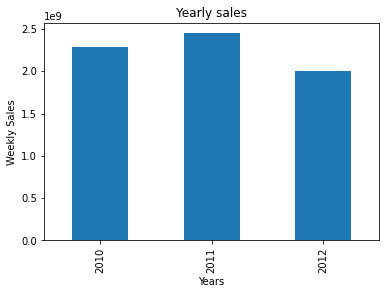

In [16]:
#con este script se pide a python graficar las Ventas Anuales
plt.figure(figsize=(20,8))
df.groupby("Year")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Years")
plt.ylabel("Weekly Sales")
plt.title("Yearly sales")
plt.show()

In [17]:
#con este script se pide a Python agrupar por Quarter
group=df.groupby("Quarter").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Quarter,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
0,1,34155,"1,501,938,357.51",0,"78,120.10","4,928.01","254,578.11","11,918.73",2986470,3060,10080,22860
1,2,40365,"1,826,038,445.58",0,"110,697.65","6,045.35","301,045.76","14,055.84",3529305,8685,33795,26865
2,3,39330,"1,748,077,899.54",90,"122,241.53","5,781.35","293,952.91","13,574.42",3438810,13680,56070,28440
3,4,34155,"1,661,164,284.48",360,"79,312.16","4,857.92","254,530.18","11,925.55",2985975,16245,67365,22545


<Figure size 1440x576 with 0 Axes>

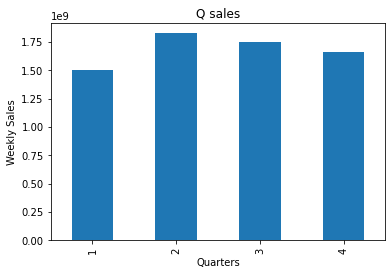

In [18]:
#con este script se pide a python graficar las Ventas by Quarter
plt.figure(figsize=(20,8))
df.groupby("Quarter")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Quarters")
plt.ylabel("Weekly Sales")
plt.title("Q sales")
plt.show()

In [19]:
#from pandas.core.groupby.groupby import DataFrame

#con este script se pide a Python realizar la suma y acumulacion por Quarter
#df=DataFrame({'Year', 'Quarter'})
#print(df.groupby(['Year', 'Quarter']).sum().groupby(level=[0]).cumsum())

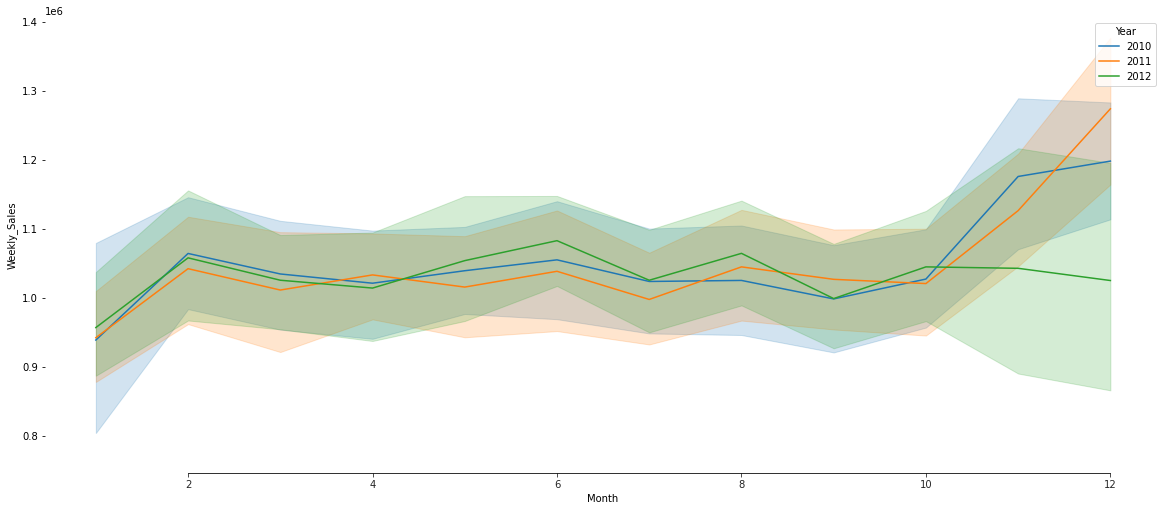

In [20]:
#con este script se pide a Python graficar las ventas por año y por mes
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

In [21]:
#con este script se pide a Python ordenar por Store 
df.set_index('Store')

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,,,,,,,,,,,,
1,2010-05-02,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,17,2
1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
1,2010-05-03,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...
45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
45,2012-05-10,"733,455.07",0,64.89,3.98,192.17,8.67,2012,2,5,19,10
45,2012-12-10,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,12,50,10


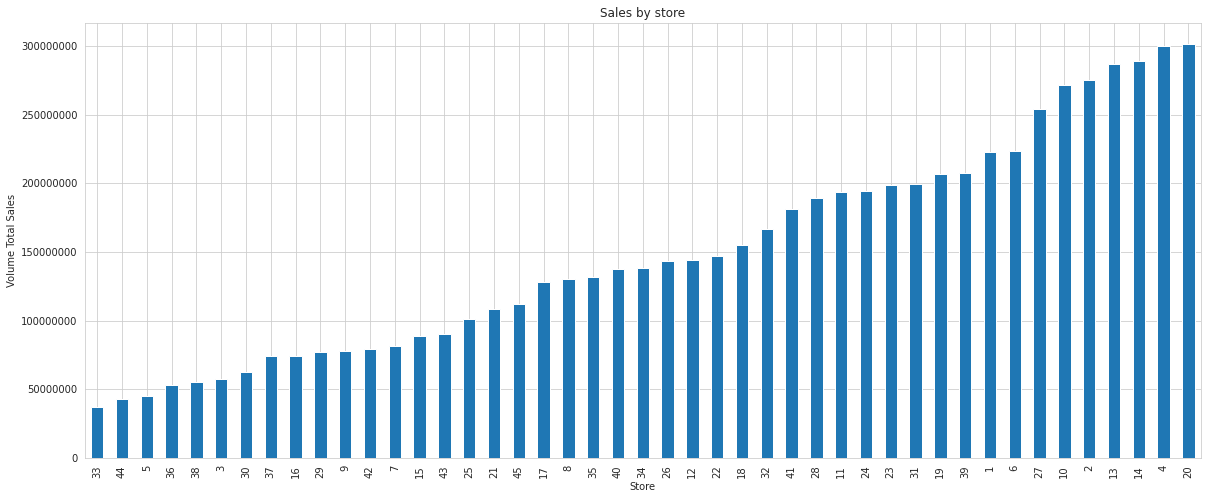

In [22]:
#con este script se pide a Python graficar las ventas por Store
Total_sales= df.groupby('Store')['Weekly_Sales'].sum().sort_values()
Total_sales_array = np.array(Total_sales)
plt.figure(figsize=(20,8))
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Sales by store')
plt.xlabel('Store')
plt.ylabel('Volume Total Sales')
Total_sales.plot(kind='bar')

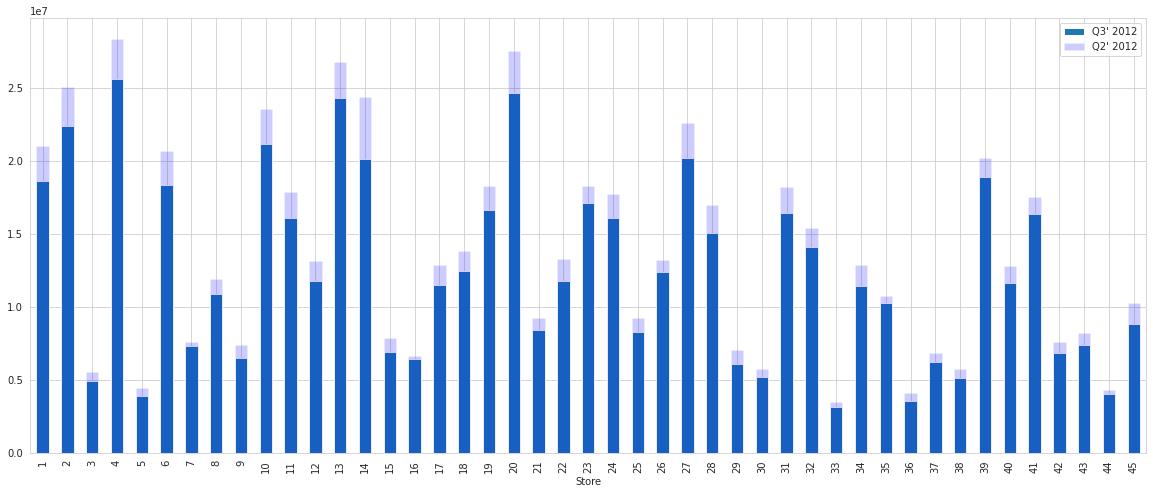

In [23]:
#con este script se agrupan las ventas por el segundo y tercer Q de 2012
Q2_sales = df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales = df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()

#con este script se grafica la diferencia en ventas por el segundo y tercer Q
plt.figure(figsize=(20,8))
Q2_sales.plot(ax=Q3_sales.plot(kind ='bar'),kind='bar',color='b',alpha=0.2,legend=True)
plt.legend(["Q3' 2012", "Q2' 2012"])

In [24]:
#en este script se determina el crecimiento entre los Q2 y Q3
Q2_sales= df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales= df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()
quarterly_growth_rate = ((Q3_sales - Q2_sales )/Q2_sales)*100
quarterly_growth_rate.sort_values(ascending=False).head()

Store
16   -2.79
7    -3.82
35   -4.66
26   -6.06
39   -6.40
Name: Weekly_Sales, dtype: float64

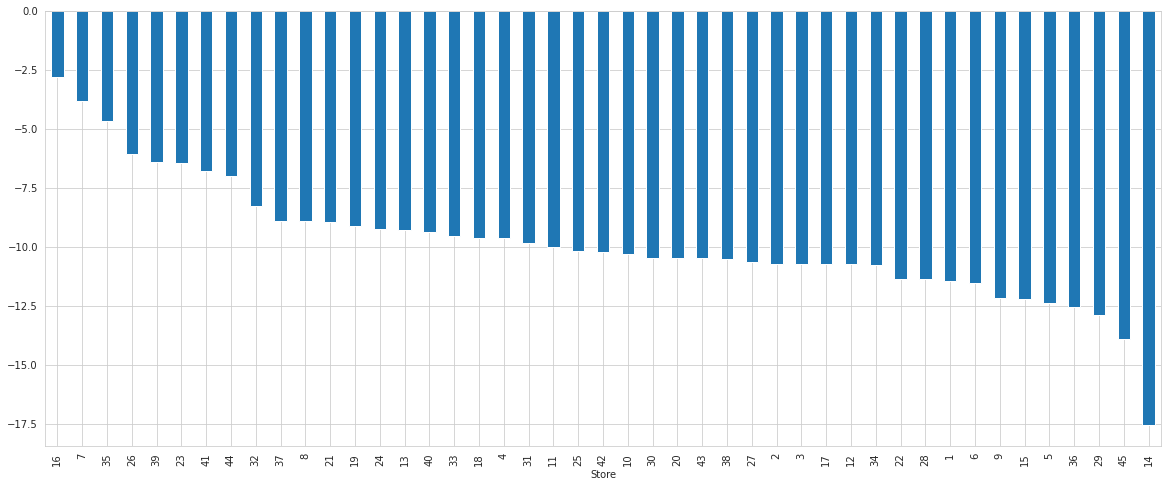

In [25]:
plt.figure(figsize=(20,8))
quarterly_growth_rate.sort_values(ascending=False).plot(kind='bar')

In [26]:
#es este script se solicita a Python calcular la Desviacion Estandar por tienda, ordenanda de mayor a menor
Store_devstd = df.groupby('Store')['Weekly_Sales'].std()
Store_devstd = pd.DataFrame(Store_devstd)
Store_devstd=Store_devstd.sort_values('Weekly_Sales', ascending=False)
Store_devstd

,Weekly_Sales
Store,
14,"317,569.95"
10,"302,262.06"
20,"275,900.56"
4,"266,201.44"
13,"265,507.00"
23,"249,788.04"
27,"239,930.14"
2,"237,683.69"
39,"217,466.45"


In [27]:
#con este script Python hace el calculo de la tienda con más desviacion estandar
top_std = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
top_std.head(1).index[0] , top_std.head(1).Weekly_Sales[top_std.head(1).index[0]] 

(14, 317569.9494755081)

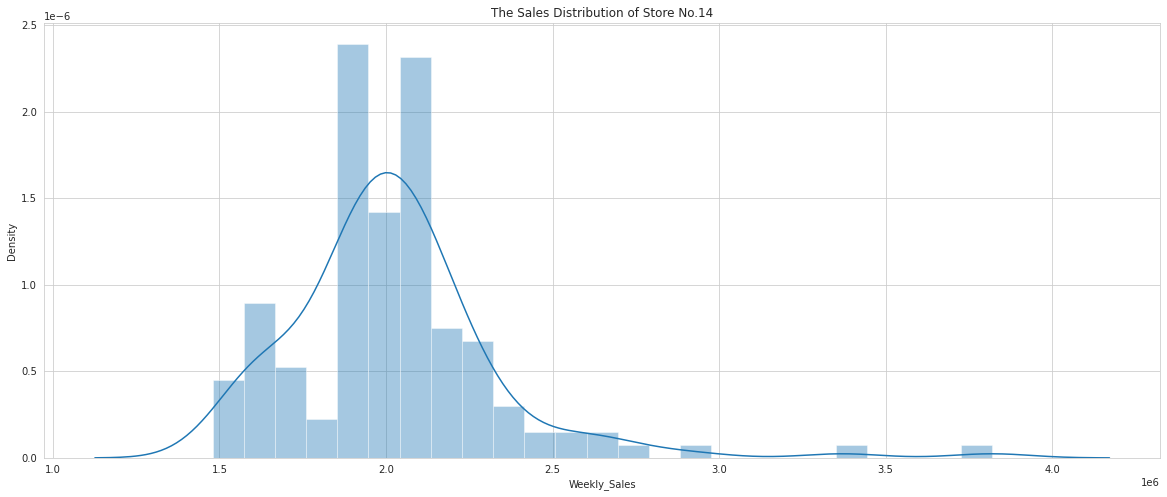

In [28]:
#con este script se pide a Python graficar la DesvStd por tienda
plt.figure(figsize=(20,8))
sns.distplot(df[df['Store'] == top_std.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store No.'+ str(top_std.head(1).index[0]))

import warnings
warnings.filterwarnings('ignore')

In [29]:
# con este script se determina el -Coeficiente de Desviación Medio- por tienda el
#se determino dividiendo la DesvStd por tienda entre la media de las tiendas, como sigue coeficiente_DM = Desviación Estandar / media aritmetica * 100
coeficiente_DM = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coeficiente_DM

,Weekly_Sales
Store,
1,10.03
2,12.34
3,11.50
4,12.71
5,11.87
6,13.58
7,19.73
8,11.70
9,12.69


In [30]:
#se pide a Python filtrar los primeros 7 datos 
coef = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coef = coef.rename(columns={'Weekly_Sales':'Coefficient of standard deviation'})
coef_max = coef.sort_values(by='Coefficient of standard deviation', ascending=False)
coef_max.head(7)

,Coefficient of standard deviation
Store,
35,22.97
7,19.73
15,19.34
29,18.37
23,17.97
21,17.03
45,16.56


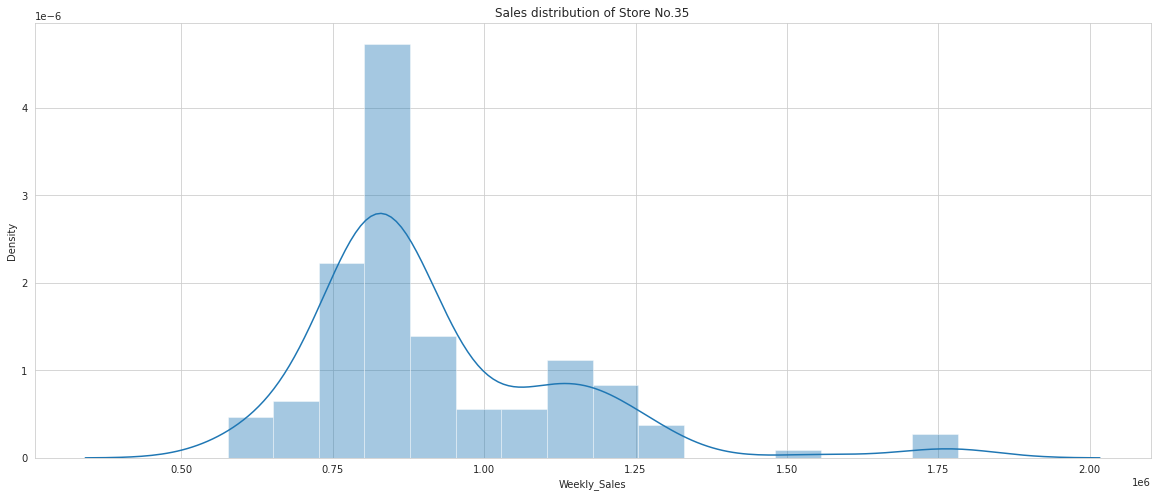

In [31]:
#con este script se pide a Python graficar la distribucion de las Ventas de acuerdo al coeficiente de desviacion standar
plt.figure(figsize=(20,8))
sns.distplot(df[df['Store'] == coef_max.head(1).index[0]]['Weekly_Sales'])
plt.title('Sales distribution of Store No.'+str(coef_max.head(1).index[0]))
import warnings
warnings.filterwarnings('ignore')

In [32]:
#con este script se pide a Python identificar los días festivos
df_Holiday=df[df["Holiday_Flag"]==1]
df_Holiday

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
1,1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
31,1,2010-10-09,"1,507,460.69",1,78.69,2.56,211.50,7.79,2010,4,10,40,9
42,1,2010-11-26,"1,955,624.11",1,64.52,2.73,211.75,7.84,2010,4,11,47,26
47,1,2010-12-31,"1,367,320.01",1,48.43,2.94,211.40,7.84,2010,4,12,52,31
53,1,2011-11-02,"1,649,614.93",1,36.39,3.02,212.94,7.74,2011,4,11,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,45,2011-09-09,"746,129.56",1,71.48,3.74,186.67,8.62,2011,3,9,36,9
6386,45,2011-11-25,"1,170,672.94",1,48.71,3.49,188.35,8.52,2011,4,11,47,25
6391,45,2011-12-30,"869,403.63",1,37.79,3.39,189.06,8.52,2011,4,12,52,30
6397,45,2012-10-02,"803,657.12",1,37.00,3.64,189.71,8.42,2012,4,10,40,2


In [33]:
#con esta instruccion se definen los Días festivos que encontro Pyton en el dataframe
Super_Bowl =['2010-12-02', '2011-11-02', '2012-10-02']
Labor_Day =  ['2010-10-09', '2011-09-09', '2012-07-09']
Thanksgivig_Day =  ['2010-11-26', '2011-11-25', '2012-11-23']
Xmas = ['2010-12-31', '2011-12-30', '2012-12-28']

In [34]:
#con este script se pide a Python sumar los dias festivos y no festivos
add_days = Super_Bowl + Labor_Day + Thanksgivig_Day + Xmas
add_days
df["Holiday_Flag"] = np.where(df["Holiday_Flag"] == 1, df["Holiday_Flag"], df["Holiday_Flag"].isin(add_days))
df['Holiday_Flag'].value_counts()

0    5985
1     450
Name: Holiday_Flag, dtype: int64

In [35]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_Festivos
Sales_Super_Bowl= (pd.DataFrame(df.loc[df.Date.isin(Super_Bowl)]))['Weekly_Sales'].mean()
Sales_Labor_Day = (pd.DataFrame(df.loc[df.Date.isin(Labor_Day)]))['Weekly_Sales'].mean()
Sales_Thanksgivig_Day = (pd.DataFrame(df.loc[df.Date.isin(Thanksgivig_Day)]))['Weekly_Sales'].mean()
Sales_Xmas = (pd.DataFrame(df.loc[df.Date.isin(Xmas)]))['Weekly_Sales'].mean()
{Sales_Super_Bowl, Sales_Labor_Day, Sales_Thanksgivig_Day, Sales_Xmas}

{960833.1115555555, 1042427.293925926, 1079127.9877037038, 1471273.427777778}

In [36]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_No_Festivos
Sales_not_Holiday = df[df['Holiday_Flag'] == 0 ]['Weekly_Sales'].mean()
{Sales_not_Holiday}

{1041256.3802088555}

In [37]:
#con esta instruccion se pide a Python determinar el promedio de ventas 
Average_sales = {'Sales_Super_Bowl' : Sales_Super_Bowl,
                 'Sales_Labor_Day': Sales_Labor_Day,
                 'Sales_Thanksgiving_Day':Sales_Thanksgivig_Day,
                 'Sales_Xmas': Sales_Xmas,
                 'Sales_not_Holiday': Sales_not_Holiday}
Average_sales 

{'Sales_Super_Bowl': 1079127.9877037038,
 'Sales_Labor_Day': 1042427.293925926,
 'Sales_Thanksgiving_Day': 1471273.427777778,
 'Sales_Xmas': 960833.1115555555,
 'Sales_not_Holiday': 1041256.3802088555}

In [38]:
df.groupby('Quarter').sum()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
Quarter,,,,,,,,,,,
1,34155,"1,501,938,357.51",0,"78,120.10","4,928.01","254,578.11","11,918.73",2986470,3060,10080,22860
2,40365,"1,826,038,445.58",0,"110,697.65","6,045.35","301,045.76","14,055.84",3529305,8685,33795,26865
3,39330,"1,748,077,899.54",90,"122,241.53","5,781.35","293,952.91","13,574.42",3438810,13680,56070,28440
4,34155,"1,661,164,284.48",360,"79,312.16","4,857.92","254,530.18","11,925.55",2985975,16245,67365,22545


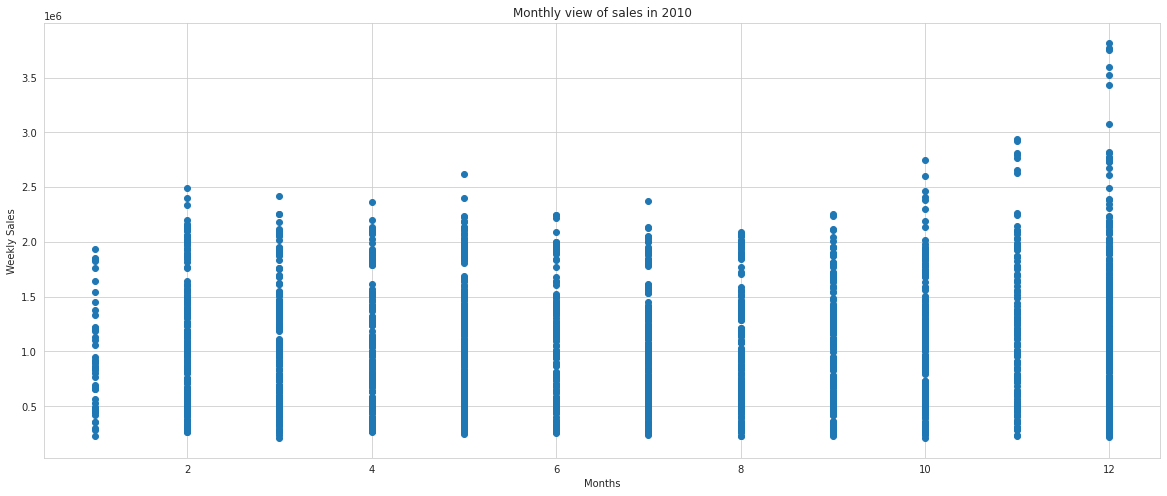

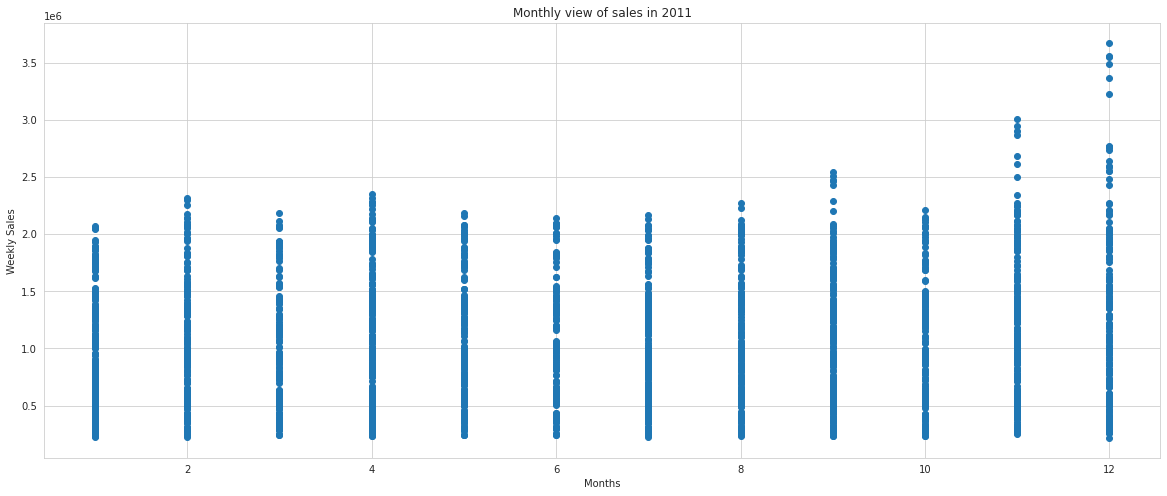

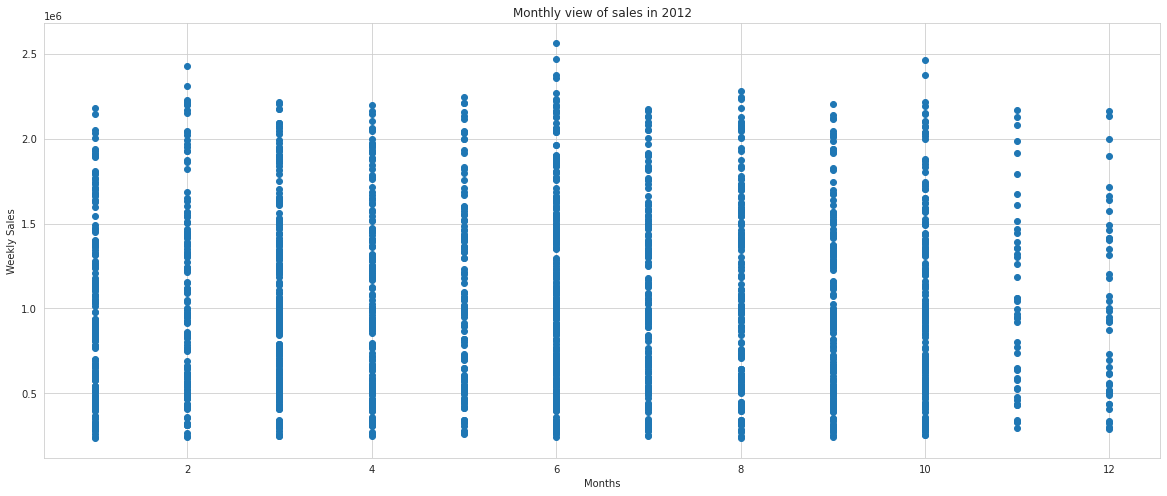

In [39]:
#con este script se pide a Python graficar las Ventas mensuales por cada año 
plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2010]["Month"],df[df.Year==2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2011]["Month"],df[df.Year==2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2012]["Month"],df[df.Year==2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

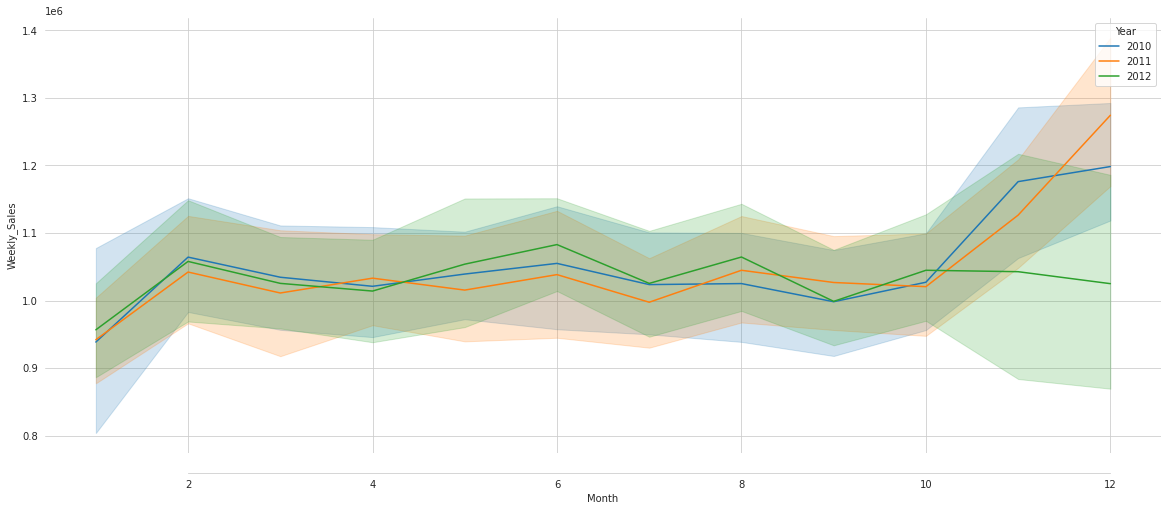

In [40]:
#con esta instrucción se pide a Python graficar las ventas de los tres años de manera mensual
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

# sección 3. **Quitar Valores de Rango**
en esta sección del codigo se analiza la información para quitar los valores fuera de rango


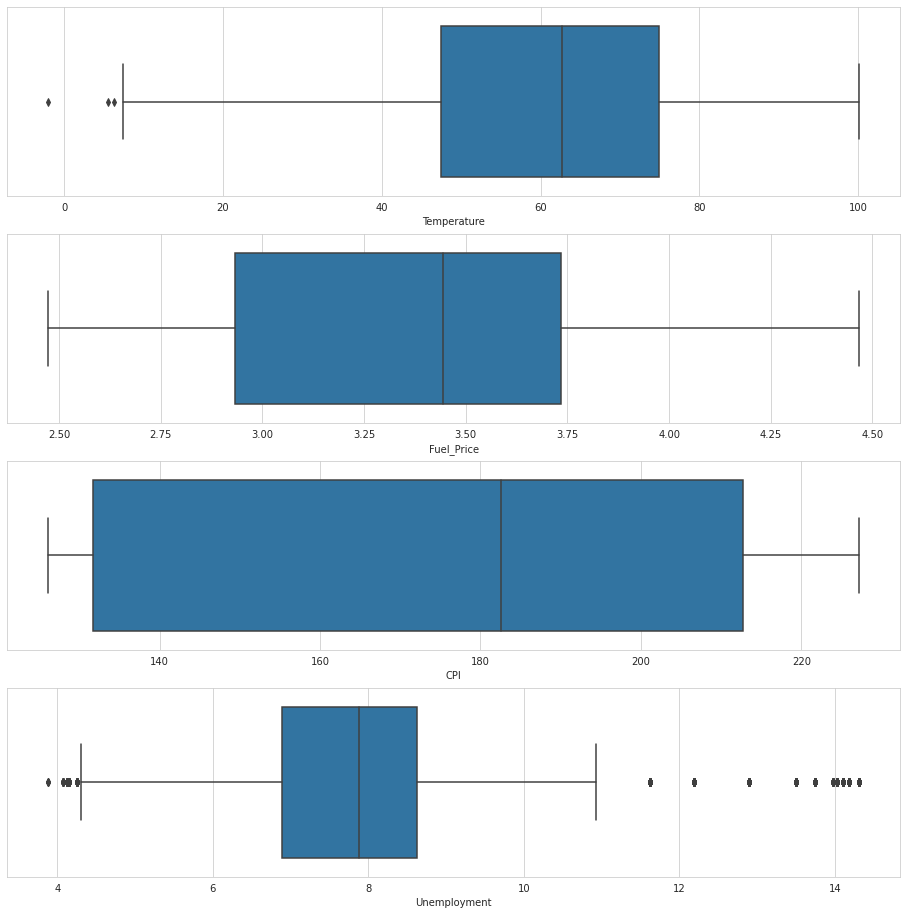

In [41]:
#con este script se grafican y validan los valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df[column],ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

In [42]:
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-05-02,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,17,2
1,1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-05-03,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-05-10,"733,455.07",0,64.89,3.98,192.17,8.67,2012,2,5,19,10
6432,45,2012-12-10,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,12,50,10
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


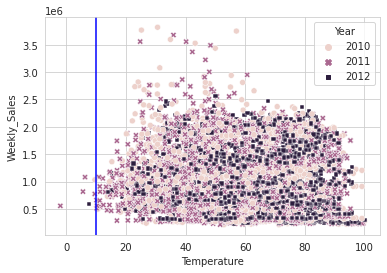

In [43]:
sns.scatterplot(data=df,x='Temperature', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=10,color='b')

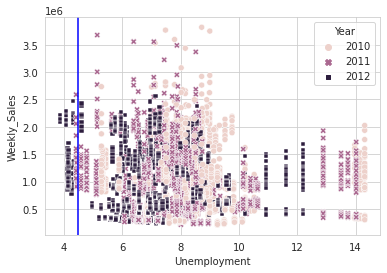

In [44]:
sns.scatterplot(data=df,x='Unemployment', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=4.5,color='b')

In [45]:
#con este script pedimos aPython eliminar los valores atipicos en una nueva función
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-05-02,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,17,2
1,1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-05-03,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-05-10,"733,455.07",0,64.89,3.98,192.17,8.67,2012,2,5,19,10
6432,45,2012-12-10,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,12,50,10
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


In [46]:
Q1 = df[['Temperature']].quantile(0.25)
print('Lower_limit_t', Q1)
Q3 = df[['Temperature']].quantile(0.75)
print('Upper_limit_t', Q3)

IQR = Q3 - Q1


Lower_limit_t Temperature   47.46
Name: 0.25, dtype: float64
Upper_limit_t Temperature   74.94
Name: 0.75, dtype: float64


In [47]:
Lower_limit_t=(Q1-1.5 * IQR)
print(Lower_limit_t)

Upper_limit_t=(Q1+1.5 * IQR)
print(Upper_limit_t)


Temperature   6.24
dtype: float64
Temperature   88.68
dtype: float64


In [48]:
Q1 = df[['Unemployment']].quantile(0.25)
print('Lower_limit_U', Q1)
Q3 = df[['Unemployment']].quantile(0.75)
print('Upper_limit_U', Q3)

Lower_limit_U Unemployment   6.89
Name: 0.25, dtype: float64
Upper_limit_U Unemployment   8.62
Name: 0.75, dtype: float64


In [49]:
Lower_limit_U=(Q1-1.5 * IQR)
print(Lower_limit_U)

Upper_limit_U=(Q1+1.5 * IQR)
print(Upper_limit_U)

Temperature    NaN
Unemployment   NaN
dtype: float64
Temperature    NaN
Unemployment   NaN
dtype: float64


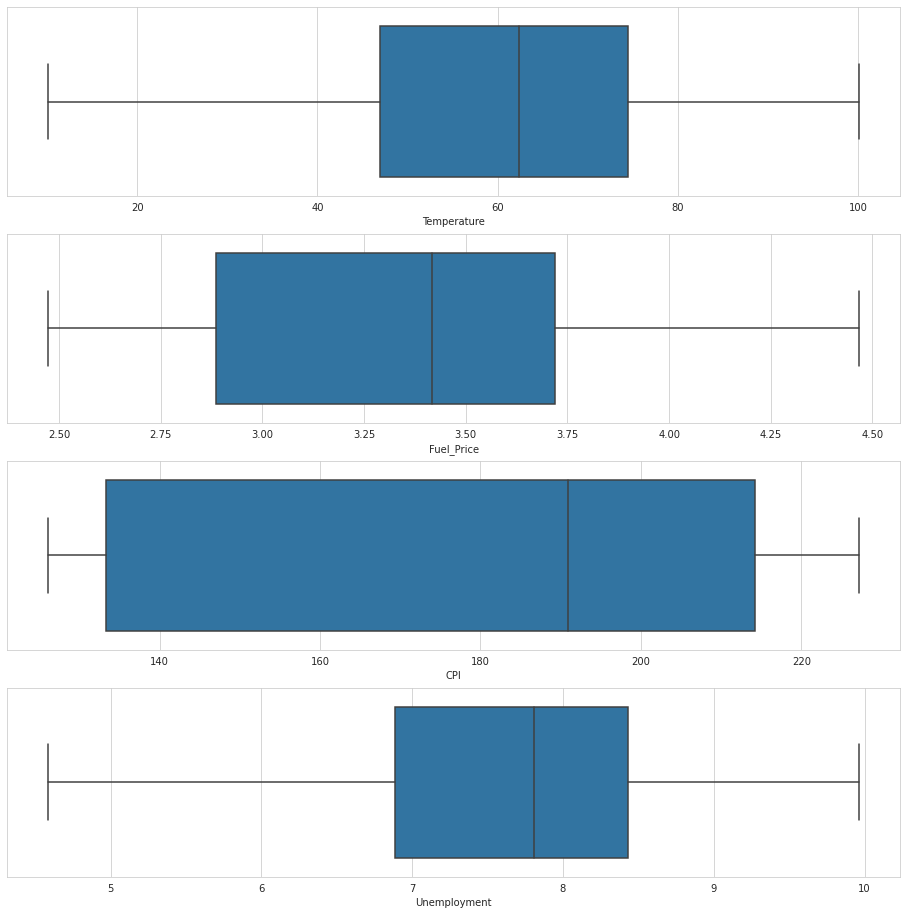

In [50]:
#se validan los datos de los outliers
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column], ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

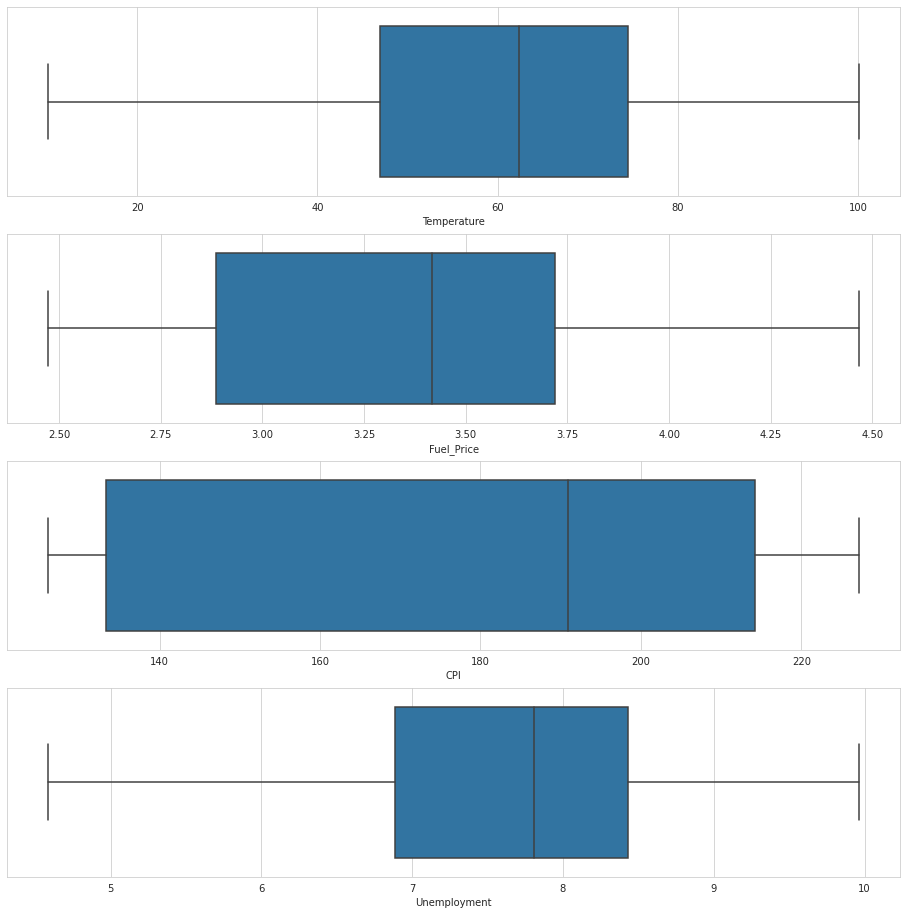

In [51]:
# Verificamos ya no tener valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column],ax=axis[i])


In [52]:
#con este script se pide a Python calcular la correlacion entre variables
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,1.00,-0.34,-0.00,-0.02,0.06,-0.21,0.22,0.00,-0.00,0.00,0.00,-0.00
Weekly_Sales,-0.34,1.00,0.04,-0.06,0.01,-0.07,-0.11,-0.02,0.06,0.07,0.07,-0.01
Holiday_Flag,-0.00,0.04,1.00,-0.16,-0.08,-0.00,0.01,-0.06,0.33,0.33,0.33,-0.04
Temperature,-0.02,-0.06,-0.16,1.00,0.14,0.18,0.10,0.06,0.07,0.07,0.07,0.09
Fuel_Price,0.06,0.01,-0.08,0.14,1.00,-0.17,-0.03,0.78,-0.05,-0.05,-0.04,0.03
CPI,-0.21,-0.07,-0.00,0.18,-0.17,1.00,-0.30,0.07,0.00,0.00,0.00,0.00
Unemployment,0.22,-0.11,0.01,0.10,-0.03,-0.30,1.00,-0.24,-0.00,-0.00,-0.01,-0.01
Year,0.00,-0.02,-0.06,0.06,0.78,0.07,-0.24,1.00,-0.13,-0.14,-0.13,-0.01
Quarter,-0.00,0.06,0.33,0.07,-0.05,0.00,-0.00,-0.13,1.00,0.97,0.97,0.01
Month,0.00,0.07,0.33,0.07,-0.05,0.00,-0.00,-0.14,0.97,1.00,1.00,0.01


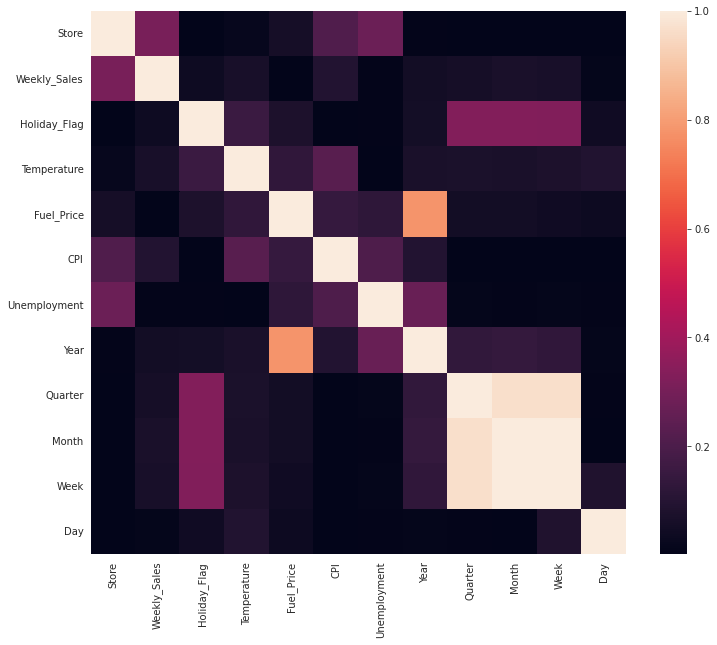

In [53]:
#con este grafico de calor podemos ver las correlaciones de las diferentes columnas, entre mas oscuro mas correlacion existe
plt.figure(figsize = (12,10))
sns.heatmap(df_clean.corr().abs())    

plt.show()

In [54]:
#sns.pairplot(df.drop('Store', axis=1))

# sección 4. **Modelos y Pronostico**

en esta sección del codigo se procede a realizar el modelado de la información

 **Times Series**

In [55]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-05-02,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,17,2
1,1,2010-12-02,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,4,12,48,2
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,1,2,7,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,1,2,8,26
4,1,2010-05-03,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,2,5,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,"713,173.95",0,64.88,4.00,192.01,8.68,2012,3,9,39,28
6431,45,2012-05-10,"733,455.07",0,64.89,3.98,192.17,8.67,2012,2,5,19,10
6432,45,2012-12-10,"734,464.36",0,54.47,4.00,192.33,8.67,2012,4,12,50,10
6433,45,2012-10-19,"718,125.53",0,56.47,3.97,192.33,8.67,2012,4,10,42,19


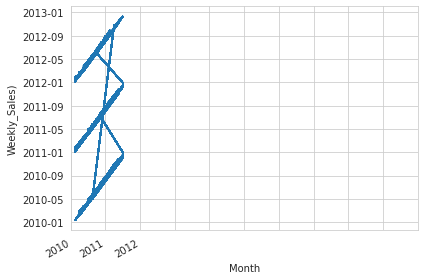

In [88]:
fig, ax = plt.subplots()

ax.plot(df.Month, df.Date)
ax.set_xlabel('Month')
ax.set_ylabel('Weekly_Sales)')

plt.xticks(np.arange(0, 85, 8), [2010, 2011, 2012])

fig.autofmt_xdate()
plt.tight_layout()

In [57]:
#plt.figure(figsize=(20, 8))
#plt.plot(df.index, df['Weekly_Sales'])

#plt.xlabel('Year', fontsize=14 )
#plt.ylabel('Quarter', fontsize=14)
#plt.title('Times series', fontsize=14)
#plt.show()

**Analisis ANOVA**

In [58]:
from scipy import stats
x=['Holiday_Flag']
y=['Weekly_Sales']
stats.kruskal(x,y)

KruskalResult(statistic=1.0, pvalue=0.31731050786291115)

In [59]:
x=df[df['Holiday_Flag'] == 0]['Weekly_Sales']
y=df[df['Holiday_Flag'] == 1]['Weekly_Sales']
stats.kruskal(x,y)

KruskalResult(statistic=4.963273167380976, pvalue=0.025891154949924652)

In [60]:
df.groupby(['Weekly_Sales'])['Holiday_Flag'].mean()

Weekly_Sales
209,986.25     0.00
213,538.32     0.00
215,359.21     1.00
219,804.85     1.00
220,060.35     0.00
               ... 
3,595,903.20   0.00
3,676,388.98   0.00
3,749,057.69   0.00
3,766,687.43   0.00
3,818,686.45   0.00
Name: Holiday_Flag, Length: 6435, dtype: float64

In [61]:
#se calcula el p_value determinando que los holiday si afectan las ventas, por lo tanto en los Holiday las ventas incrementan
from scipy.stats import f_oneway
f_oneway(x,y)

F_onewayResult(statistic=8.766880898711571, pvalue=0.0030786992638024567)

**Linear Regression**

In [62]:
#con este script se calcula la regresion lineal or linear Regression :
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
X = df_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
Y = df_clean['Weekly_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

Linear Regression:

Accuracy: 12.506646396697485
Mean Absolute Error: 432881.7692142086
Mean Squared Error: 265286117261.1807
Root Mean Squared Error: 515059.33372882457


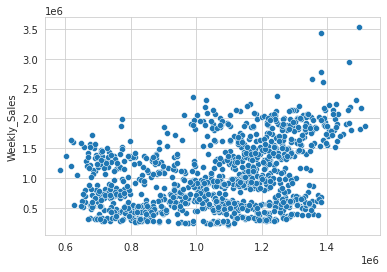

In [63]:
print('Linear Regression:')
print()
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print('Accuracy:',reg.score(X_train, Y_train)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)

import warnings
warnings.filterwarnings('ignore')

Random Forest Regressor:

Accuracy: 96.08049124804232
Mean Absolute Error: 62113.577923321565
Mean Squared Error: 12105762222.801188
Root Mean Squared Error: 110026.1888043078


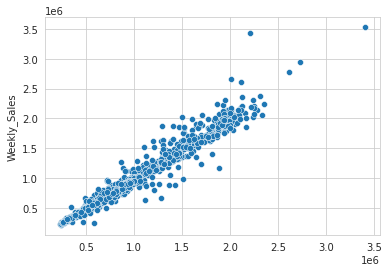

In [64]:
#se calcula el random forest regressor
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regressor:')
print()
rfr = RandomForestRegressor()        
rfr.fit(X_train,Y_train)
Y_pred = rfr.predict(X_test)
print('Accuracy:',rfr.score(X_test, Y_test)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)


import warnings
warnings.filterwarnings('ignore')

In [65]:
#con este script se solicita a Python calcular el analsis de variaza entre 'Holiday_ Flag' vs 'Weekly_Sales', el modelo indica que la variacion
#afecta las ventas de manera significativa

model = smf.ols ('Holiday_Flag ~ Weekly_Sales', data = df).fit()
aov_table = anova_lm(model, type=2)
anova_result = sm.stats.anova_lm(model, type=2)
print(aov_table)

                   df  sum_sq  mean_sq    F  PR(>F)
Weekly_Sales     1.00    0.57     0.57 8.77    0.00
Residual     6,433.00  417.96     0.06  NaN     NaN


In [66]:
import prophet as ppt

In [67]:
import scipy.stats as stats
from pmdarima import auto_arima

In [68]:
df_arima=df
df_arima=df_arima.set_index('Date')

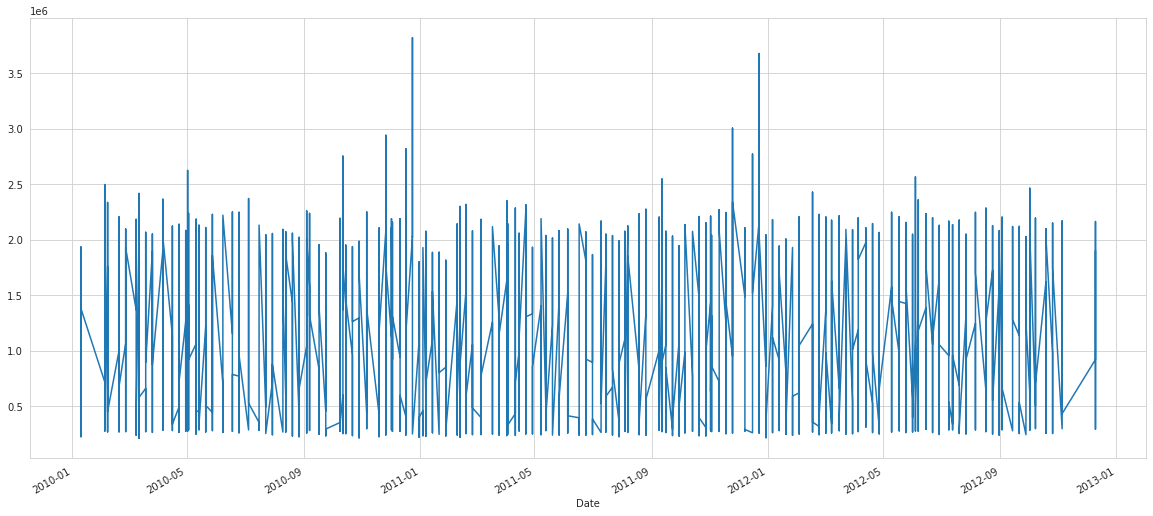

In [69]:
plt.figure(figsize=(20,9))
df_arima['Weekly_Sales'].plot()
plt.show()

In [70]:
df_arimamonth = df_arima.resample('M').mean()

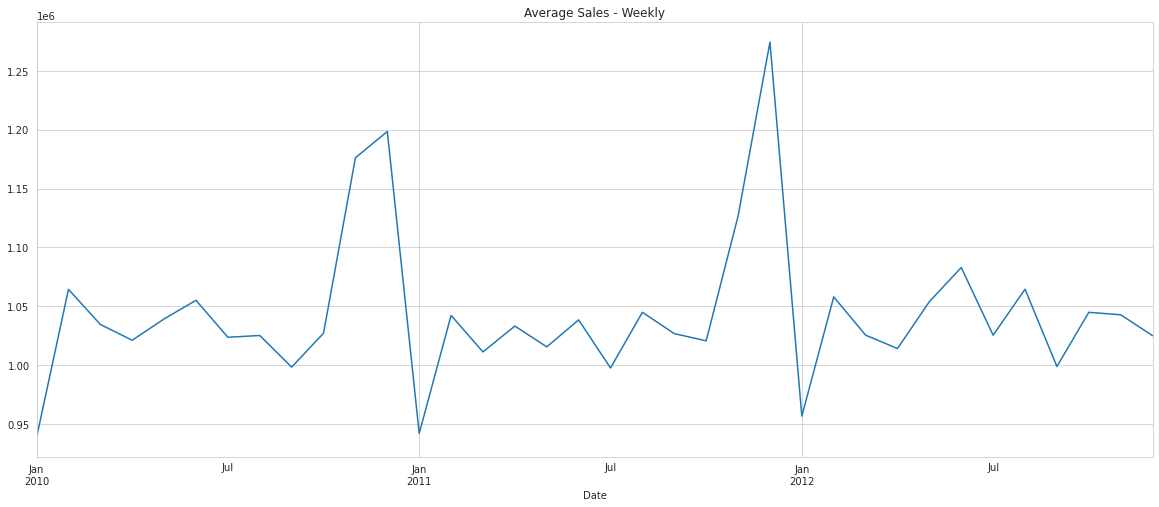

In [71]:
plt.figure(figsize=(20,8))
df_arimamonth['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [72]:
train_data = df_arimamonth[:int(0.7*(len(df_arimamonth)))] 
test_data = df_arimamonth[int(0.7*(len(df_arimamonth))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (25, 12)
Test: (11, 12)


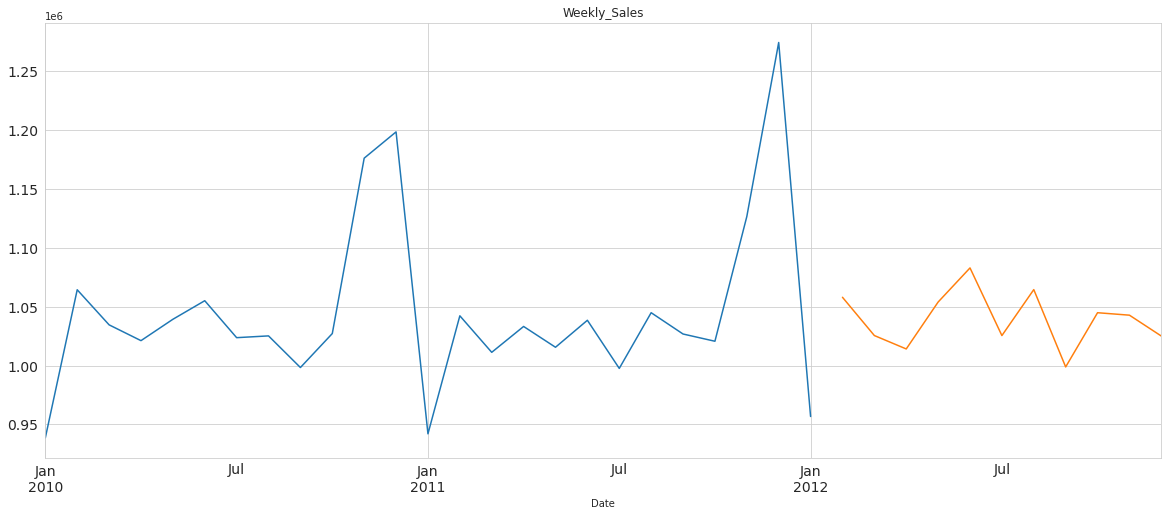

In [73]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [74]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff (df_arimamonth['Weekly_Sales'])

(0.06962834103894028, True)

In [75]:
model_auto_arima = auto_arima(train_data['Weekly_Sales'], trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=0, max_D=0,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data['Weekly_Sales'])

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=636.012, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=638.061, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=638.990, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=640.674, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=643.154, Time=0.05 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=638.042, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=639.842, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=641.974, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=637.959, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=640.130, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=642.772, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=641.711, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   :

ARIMA(maxiter=200, order=(0, 0, 0), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

In [76]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:                        SARIMAX   Log Likelihood                -316.006
Date:                Tue, 08 Nov 2022   AIC                            636.012
Time:                        20:20:49   BIC                            638.450
Sample:                    01-31-2010   HQIC                           636.688
                         - 01-31-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.045e+06   2.13e+04     48.969      0.000       1e+06    1.09e+06
sigma2      5.581e+09   1.58e+09      3.534      0.000    2.49e+09    8.68e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               5.22   Skew:                             1.44
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
#y_pred = model_auto_arima.predict(n_periods=len(test_data['Weekly_Sales']))
#y_pred = pd.DataFrame(y_pred,index = test_data['Weekly_Sales'].index,columns=['Prediction'])
#plt.figure(figsize=(20,6))
#plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(train_data['Weekly_Sales'], label='Train')
#plt.plot(test_data['Weekly_Sales'], label='Test')
#plt.plot(y_pred, label='Prediction of ARIMA')
#plt.legend(loc='best')
#plt.xlabel('Date', fontsize=14)
#plt.ylabel('Weekly Sales', fontsize=14)
#plt.show()

In [78]:
#con este escript se elige el tipo de modelo

#import statsmodels as sm
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.stattools import adfuller
#def test_stationarity(timeseries):

#estadisticas en la determinación de la media móvil y la desviación estandar
#  rolmean = pd.rolling_mean(timeseries, window=12)
#  rolstd = pd.rolling_std(timeseries, window=12)

#graficar las estadisticas
#  orig = plt.plot(timeseries, color="blue", label="Original")
#  mean = plt.plot(rolmean, color="red", label="Media Movil")
#  std = plt.plot(rolstd, color="black", label="Desviacon Estandar")
#  plt.legend(loc="best")
#  plt.title("Media Movil y Desviacion Estandar")
#  plt.show(block=False)

#calculo de la media movil
#moving_avg = pd.rolling_mean(datos["Weekly_Sales"], 12)
#datos["Weekly_Sales"]

#grafica de la media movil
#moving_avg.plot(label="Media Movil", color="red")
#plt.legend(loc="best")

#from statsmodels.tsa.stattools import adfuller
#def test_stationarity(timeseries):
    #determine rolling statistics
#    rolmean = pd.Series(timeseries).rolling(window=24).mean()#24 hours on each day
#    rolstd = pd.Series(timeseries).rolling(window=24).std()
#    #plot rolling statistics
#    orig = plt.plot(timeseries,color = 'blue',label='original')
#    mean = plt.plot(rolmean,color = 'red',label = 'rolling mean')
#    std = plt.plot(rolstd,color = 'black',label = 'rolling std')
#    plt.legend(loc = 'best')
#    plt.title('rolling mean and standard deviation')
#    plt.show(block = False)

   #perform dickey fuller test
#    print('result of dickey fuller test:')
#    dftest = adfuller(timeseries,autolag = 'AIC')
#    dfoutput = pd.Series(dftest[0:4],index = ['Test statistics', 'p-value', '#lags used', 'number of observation used'])
#    for key,value in dftest[4].items():
#        dfoutput['critical value (%s)'%key] = value
#    print(dfoutput)

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 20,10
#test_stationarity(train_original['Count'])


In [79]:
#df = px.data.gapminder()
#Weekly_Sales = df.query("Weekly_Sales")

#for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
#    fig = px.scatter(Weekly_Sales,
#                     x="gdpPercap", y="lifeExp", size="pop", color="continent",
#                     log_x=True, size_max=60,
#                     template=template, title="Gapminder 2007: '%s' theme" % template)
#    fig.show()

#df = px.data.gapminder()
#df_2007 = df.query("year==2007")

#for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
#    fig = px.scatter(df_2007,
#                     x="gdpPercap", y="lifeExp", size="pop", color="continent",
#                     log_x=True, size_max=60,
#                     template=template, title="Gapminder 2007: '%s' theme" % template)
#    fig.show()

In [80]:
#f.["Temperature"].plot(figsize=(20,8))

#df.plot()

In [81]:
#plt.plot(test)

#train = df_clean['Weekly_Sales']
#test = df_clean['Weekly_Sales']
#plt.plot(train)
#plt.plot(test)

In [82]:
#plt.figure(figsize=(50,6))
#df_clean['Weekly_Sales'].plot()

In [83]:
#model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
#                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
#                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
#                  error_action='ignore',approximation = False)
#model_auto_arima.fit(train_data_diff)

In [84]:
#X = df_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
#y = df_clean['Weekly_Sales']

In [85]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

In [86]:
#from sklearn.linear_model import LinearRegression

#model = LinearRegression()
#model.fit(X_train,y_train)